In [1]:
import torch
import torchvision
from torchvision import transforms, utils, models
from torchvision.io import read_image
from torch.utils.data import DataLoader, Dataset
from random import randint

import psycopg2,datetime,heapq

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib

import os
import shutil

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
# from sklearn.metrics.pairwise import cosine_similarity


import seaborn as sns

import random
import ipyplot
from tqdm import tqdm
from livelossplot import PlotLosses

torch.manual_seed(4096)


def readgroup():
    #Group List
    #os.chdir('/home/jack/4_Selenium')
    with open("top.txt",encoding="utf-8") as f:
        top = f.read().split("\n")
    with open("all.txt",encoding="utf-8") as f:
        allg = f.read().split("\n")
    #print(top,allg)

    run = {}
    for x in allg:
        #print(x)
        if x in top:
            head = x[:2]
            #print(head)
        else:
            #run.append((head+"-"+x[1]+"-00",x[3:]))
            run[head+"-"+x[1]+"-00"] = x[3:]
    # for i in run:
    #     print(i)
    #print(len(run))
    return run
labels_dict = readgroup()
# labels_dict

In [176]:
conn = psycopg2.connect(database="trademark1", user="tm_root", password="roottm_9823a", host="trueint.lu.im.ntu.edu.tw", port="5433")
cur = conn.cursor()

# 從資料庫撈出純圖片資料

In [8]:
%%time
caseno_list = []
cur.execute("SELECT trademark.caseno, trademark.doc, trademark.Trademark_Design, rcp.FileName, \
            img_content.category \
            FROM trademark  INNER JOIN  rcc ON (trademark.caseno = rcc.caseno) \
             INNER JOIN rcp ON ( trademark.caseno = rcp.caseno  ) \
             INNER JOIN text ON (trademark.caseno = text.caseno) \
             INNER JOIN img_content ON ( trademark.caseno = img_content.caseno )\
where ( text.chinese is null and text.english is null and text.japanese is null and text.symbol is null) \
        ") 
r = cur.fetchall()

CPU times: user 70 ms, sys: 17.8 ms, total: 87.8 ms
Wall time: 386 ms


In [4]:
caseno_list += [i for i in r]
len(caseno_list)

120390

## Store

In [5]:
data = pd.DataFrame(caseno_list, columns=['caseno', 'doc', 'design', 'filename', 'content'])
data['path'] = '/service/trademark/raw_register_data/' + data.doc+ '/' + data.filename
data.dropna(inplace=True)
data.to_csv('img_index.csv', index=False)

In [3]:
data = pd.read_csv('img_index.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120390 entries, 0 to 120389
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   caseno    120390 non-null  int64 
 1   doc       120390 non-null  object
 2   design    120390 non-null  object
 3   filename  120390 non-null  object
 4   content   120390 non-null  object
 5   path      120390 non-null  object
dtypes: int64(1), object(5)
memory usage: 5.5+ MB


In [4]:
data.head(20)

caseno                      doc    design  \
0    99046726  TrademarkRegXMLB_038017  (彩色)(平面)   
1    99023943  TrademarkRegXMLB_038017  (彩色)(平面)   
2   100001296  TrademarkRegXMLB_038017  (墨色)(平面)   
3   100001296  TrademarkRegXMLB_038017  (墨色)(平面)   
4    99032164  TrademarkRegXMLB_038017  (墨色)(平面)   
5   100015811  TrademarkRegXMLB_038017  (彩色)(平面)   
6   100015811  TrademarkRegXMLB_038017  (彩色)(平面)   
7   100007848  TrademarkRegXMLB_038017  (墨色)(平面)   
8    99047821  TrademarkRegXMLB_038017  (彩色)(平面)   
9    99047821  TrademarkRegXMLB_038017  (彩色)(平面)   
10   99046388  TrademarkRegXMLB_038017  (墨色)(平面)   
11   99046388  TrademarkRegXMLB_038017  (墨色)(平面)   
12   99046388  TrademarkRegXMLB_038017  (墨色)(平面)   
13   99046388  TrademarkRegXMLB_038017  (墨色)(平面)   
14   99054097  TrademarkRegXMLB_038017  (彩色)(平面)   
15   99054097  TrademarkRegXMLB_038017  (彩色)(平面)   
16   99054097  TrademarkRegXMLB_038017  (彩色)(平面)   
17   99054097  TrademarkRegXMLB_038017  (彩色)(平面)   
18   99054098  TrademarkRegXMLB_038017  (彩色)(平面)   
19   99054098  TrademarkRegXMLB_038017  (彩色)(平面)   

                                   filename  content  \
0   imagesdata/egimg_099046726_1_038017.jpg  04-D-00   
1   imagesdata/egimg_099023943_1_038017.jpg  12-G-00   
2   imagesdata/egimg_100001296_1_038017.jpg  12-G-00   
3   imagesdata/egimg_100001296_1_038017.jpg  12-E-00   
4   imagesdata/egimg_099032164_1_038017.jpg  02-B-00   
5   imagesdata/egimg_100015811_1_038017.jpg  12-A-00   
6   imagesdata/egimg_100015811_1_038017.jpg  12-E-00   
7   imagesdata/egimg_100007848_1_038017.jpg  01-H-00   
8   imagesdata/egimg_099047821_1_038017.jpg  01-G-00   
9   imagesdata/egimg_099047821_1_038017.jpg  02-B-00   
10  imagesdata/egimg_099046388_1_038017.jpg  03-B-00   
11  imagesdata/egimg_099046388_1_038017.jpg  01-H-00   
12  imagesdata/egimg_099046388_1_038017.jpg  12-D-00   
13  imagesdata/egimg_099046388_1_038017.jpg  01-G-00   
14  imagesdata/egimg_099054097_1_038017.jpg  06-M-00   
15  imagesdata/egimg_099054097_1_038017.jpg  12-C-00   
16  imagesdata/egimg_099054097_1_038017.jpg  06-M-00   
17  imagesdata/egimg_099054097_1_038017.jpg  12-C-00   
18  imagesdata/egimg_099054098_1_038017.jpg  04-B-00   
19  imagesdata/egimg_099054098_1_038017.jpg  04-B-00   

                                                 path  
0   /service/trademark/raw_register_data/Trademark...  
1   /service/trademark/raw_register_data/Trademark...  
2   /service/trademark/raw_register_data/Trademark...  
3   /service/trademark/raw_register_data/Trademark...  
4   /service/trademark/raw_register_data/Trademark...  
5   /service/trademark/raw_register_data/Trademark...  
6   /service/trademark/raw_register_data/Trademark...  
7   /service/trademark/raw_register_data/Trademark...  
8   /service/trademark/raw_register_data/Trademark...  
9   /service/trademark/raw_register_data/Trademark...  
10  /service/trademark/raw_register_data/Trademark...  
11  /service/trademark/raw_register_data/Trademark...  
12  /service/trademark/raw_register_data/Trademark...  
13  /service/trademark/raw_register_data/Trademark...  
14  /service/trademark/raw_register_data/Trademark...  
15  /service/trademark/raw_register_data/Trademark...  
16  /service/trademark/raw_register_data/Trademark...  
17  /service/trademark/raw_register_data/Trademark...  
18  /service/trademark/raw_register_data/Trademark...  
19  /service/trademark/raw_register_data/Trademark...

### 因為多標籤，同一個caseno會出現多次

In [5]:
data.sort_values('caseno').head(5)

caseno                      doc    design  \
11704  99000467  TrademarkRegXMLB_041001  (彩色)(平面)   
11703  99000467  TrademarkRegXMLB_041001  (彩色)(平面)   
11702  99000467  TrademarkRegXMLB_041001  (彩色)(平面)   
95680  99001415  TrademarkRegXMLB_039024  (彩色)(平面)   
95681  99001415  TrademarkRegXMLB_039024  (彩色)(平面)   

                                      filename  content  \
11704  imagesdata/egimg_099000467_1_041001.jpg  02-D-00   
11703  imagesdata/egimg_099000467_1_041001.jpg  12-D-00   
11702  imagesdata/egimg_099000467_1_041001.jpg  02-G-00   
95680  imagesdata/egimg_099001415_1_039024.jpg  12-B-00   
95681  imagesdata/egimg_099001415_1_039024.jpg  11-B-00   

                                                    path  
11704  /service/trademark/raw_register_data/Trademark...  
11703  /service/trademark/raw_register_data/Trademark...  
11702  /service/trademark/raw_register_data/Trademark...  
95680  /service/trademark/raw_register_data/Trademark...  
95681  /service/trademark/raw_register_data/Trademark...

In [6]:
print(f"有{data.caseno.value_counts().shape[0]}個unique caseno (圖片)")
# data = data[ data['design'] =='(彩色)(平面)' ]

有46086個unique caseno (圖片)


In [7]:
# data = data[(data['design'] == '(墨色)(平面)') | ( data['design'] =='(彩色)(平面)' )]
data = data[ data['design'] =='(墨色)(平面)' ].drop_duplicates(keep='first')

In [10]:
print(f"墨色平面有{data.caseno.value_counts().shape[0]}張")
print(f"total numbers of labels :{data.content.value_counts().shape[0]}")

墨色平面有32067張
total numbers of labels :94


## Multi-hot encoding

### 為了解決caseno重複問題 新增兩張表 df_path & df_labels

In [11]:
a = pd.concat([data.caseno, pd.get_dummies(data.content)], axis=1).groupby('caseno').sum()
# max(a)
df_labels = a.astype('float32')
df_labels

01-A-00  01-B-00  01-C-00  01-D-00  01-E-00  01-F-00  01-G-00  \
caseno                                                                     
99001632       0.0      0.0      0.0      0.0      0.0      0.0      0.0   
99003959       0.0      0.0      0.0      0.0      0.0      0.0      0.0   
99003964       0.0      0.0      0.0      0.0      0.0      0.0      0.0   
99005409       0.0      0.0      1.0      0.0      0.0      0.0      0.0   
99005410       0.0      0.0      1.0      0.0      0.0      0.0      0.0   
...            ...      ...      ...      ...      ...      ...      ...   
109880322      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
109880323      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
109880385      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
109880386      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
109880621      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

           01-H-00  02-A-00  02-B-00  ...  12-C-00  12-D-00  12-E-00  12-F-00  \
caseno                                ...                                       
99001632       0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
99003959       0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
99003964       0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
99005409       0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
99005410       0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
...            ...      ...      ...  ...      ...      ...      ...      ...   
109880322      0.0      0.0      0.0  ...      0.0      0.0      1.0      0.0   
109880323      0.0      0.0      0.0  ...      0.0      0.0      1.0      0.0   
109880385      0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
109880386      0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
109880621      0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   

           12-G-00  12-H-00  13-B-00  13-E-00  13-F-00  13-L-00  
caseno                                                           
99001632       0.0      0.0      0.0      0.0      0.0      0.0  
99003959       0.0      0.0      0.0      0.0      0.0      0.0  
99003964       0.0      0.0      0.0      0.0      0.0      0.0  
99005409       0.0      0.0      0.0      0.0      0.0      0.0  
99005410       0.0      0.0      0.0      0.0      0.0      0.0  
...            ...      ...      ...      ...      ...      ...  
109880322      0.0      0.0      0.0      0.0      0.0      0.0  
109880323      0.0      0.0      0.0      0.0      0.0      0.0  
109880385      0.0      0.0      0.0      0.0      0.0      0.0  
109880386      0.0      0.0      0.0      0.0      0.0      0.0  
109880621      0.0      0.0      0.0      0.0      0.0      0.0  

[32067 rows x 94 columns]

In [12]:
df_labels.describe()

01-A-00       01-B-00       01-C-00       01-D-00       01-E-00  \
count  32067.000000  32067.000000  32067.000000  32067.000000  32067.000000   
mean       0.037889      0.032276      0.034272      0.008576      0.026102   
std        0.190932      0.176735      0.181930      0.092209      0.159440   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

            01-F-00       01-G-00       01-H-00       02-A-00       02-B-00  \
count  32067.000000  32067.000000  32067.000000  32067.000000  32067.000000   
mean       0.016746      0.128107      0.063305      0.045904      0.142764   
std        0.128321      0.334214      0.243514      0.209280      0.349837   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

       ...       12-C-00       12-D-00       12-E-00       12-F-00  \
count  ...  32067.000000  32067.000000  32067.000000  32067.000000   
mean   ...      0.083294      0.044657      0.058939      0.135716   
std    ...      0.276331      0.206552      0.235514      0.342492   
min    ...      0.000000      0.000000      0.000000      0.000000   
25%    ...      0.000000      0.000000      0.000000      0.000000   
50%    ...      0.000000      0.000000      0.000000      0.000000   
75%    ...      0.000000      0.000000      0.000000      0.000000   
max    ...      1.000000      1.000000      1.000000      1.000000   

            12-G-00       12-H-00       13-B-00       13-E-00       13-F-00  \
count  32067.000000  32067.000000  32067.000000  32067.000000  32067.000000   
mean       0.157826      0.012942      0.000094      0.000062      0.000062   
std        0.364583      0.113025      0.009672      0.007897      0.007897   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

            13-L-00  
count  32067.000000  
mean       0.000094  
std        0.009672  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        1.000000  

[8 rows x 94 columns]

In [13]:
df_path = data[['caseno', 'filename', 'path' ]].drop_duplicates().set_index('caseno')
df_path

filename  \
caseno                                               
100001296  imagesdata/egimg_100001296_1_038017.jpg   
99032164   imagesdata/egimg_099032164_1_038017.jpg   
100007848  imagesdata/egimg_100007848_1_038017.jpg   
99046388   imagesdata/egimg_099046388_1_038017.jpg   
99062418   imagesdata/egimg_099062418_1_038018.jpg   
...                                            ...   
108081013  imagesdata/egimg_108081013_1_047013.jpg   
109004772  imagesdata/egimg_109004772_1_047014.jpg   
108059619  imagesdata/egimg_108059619_1_047014.jpg   
108059623  imagesdata/egimg_108059623_1_047014.jpg   
108075707  imagesdata/egimg_108075707_1_047014.jpg   

                                                        path  
caseno                                                        
100001296  /service/trademark/raw_register_data/Trademark...  
99032164   /service/trademark/raw_register_data/Trademark...  
100007848  /service/trademark/raw_register_data/Trademark...  
99046388   /service/trademark/raw_register_data/Trademark...  
99062418   /service/trademark/raw_register_data/Trademark...  
...                                                      ...  
108081013  /service/trademark/raw_register_data/Trademark...  
109004772  /service/trademark/raw_register_data/Trademark...  
108059619  /service/trademark/raw_register_data/Trademark...  
108059623  /service/trademark/raw_register_data/Trademark...  
108075707  /service/trademark/raw_register_data/Trademark...  

[32067 rows x 2 columns]

## EDA

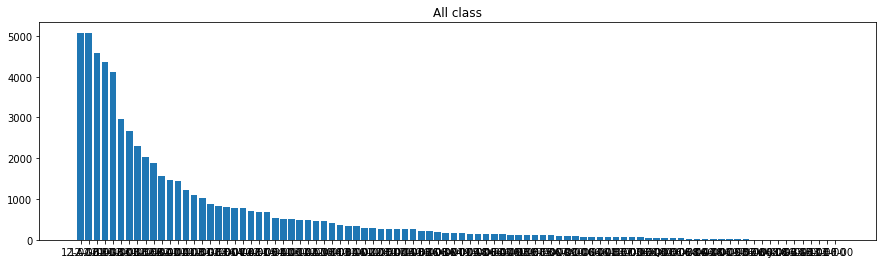

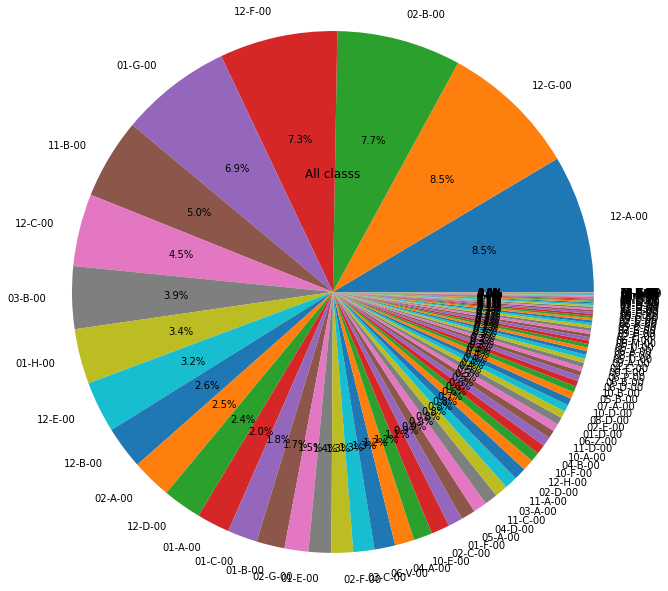

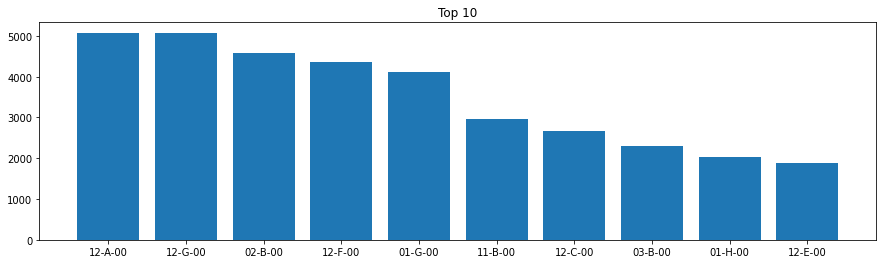

['圓形外觀', '不同幾何形狀組合/重疊或其他不規則圖形(不包含線條)', '走獸', '線條/曲折區塊或其與幾何圖形之組合/重疊(對稱係指整體構圖而言)', '擬人化', '圖形化英文', '四角形外觀', '花/葉/草', '人體部位', '特定形狀圖形']


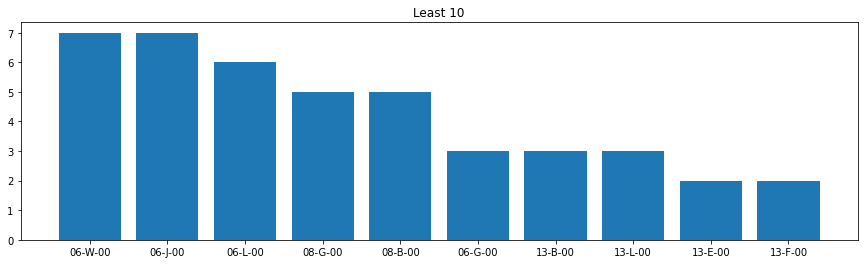

['敲鐘/鈴鐺(不含時鐘)', '衛浴設備(馬桶.浴缸.洗臉檯.水龍頭)', '吸煙用品(煙斗.香煙.煙灰缸.打火機)', '其他紡織品(桌巾.窗簾)', '下身衣物', '消防設備(滅火器.消防栓.雲梯)', '動物', '抽象幾何圖形', '建築物', '器物']


In [14]:
y = df_labels.sum().sort_values(ascending=False)
x = df_labels.sum().sort_values(ascending=False).index
chinese_labels = [labels_dict[i] for i in x]
plt.figure(figsize=(15,4))
plt.bar(x, y)
plt.title("All class")
plt.show()

plt.pie(y, labels=x,radius=3,autopct='%1.1f%%')
plt.title("All classs")
plt.show()

plt.figure(figsize=(15,4))
plt.bar(x[:10], y[:10])
plt.title("Top 10")
plt.show()
print(chinese_labels[:10])


plt.figure(figsize=(15,4))
plt.bar(x[-10:], y[-10:])
plt.title("Least 10")
plt.show()
print(chinese_labels[-10:])


In [15]:
df_labels.sum(axis=1).describe()

count    32067.000000
mean         1.855927
std          0.837930
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          9.000000
dtype: float64

平均每張圖片有1.9個標籤  
最多的有9個標籤

## 標籤最多的圖片

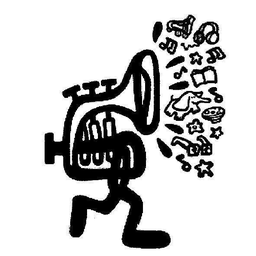

102069495
擬人化 ; 人體部位 ; 走獸 ; 家用電器(電視.冰箱.吹風機.插頭.耳機) ; 文具事務用品(筆.紙.刀片.印章.書.圓規.圖畫.掛畫) ; 樂器(打擊樂器.弦樂器.鍵盤樂器) ; 光學用品(鏡片.眼鏡.放大鏡.顯微鏡) ; 符號 ; 五角形以上外觀


In [23]:
df_labels.iloc[df_labels.sum(axis=1).argmax()].name
labels = []
for j in df_labels.columns:
    if df_labels.loc[df_labels.iloc[df_labels.sum(axis=1).argmax()].name][j] > 0:
        labels.append(j)
a = [labels_dict[i] for i in labels]
img = Image.open(df_merge.loc[df_labels.iloc[df_labels.sum(axis=1).argmax()].name].path)
img = img.resize((2*128,2*128),Image.ANTIALIAS)
display(img)
print(df_labels.iloc[df_labels.sum(axis=1).argmax()].name)
print(f"{' ; '.join(a)}")

### Show 出少數類別的圖片

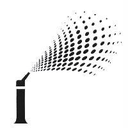

99060365
消防設備(滅火器.消防栓.雲梯) ; 廚房設備/器皿(叉.盆.碗.壺.瓶.汽水瓶.鼎.尊.花瓶.杯子.杵臼)


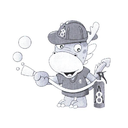

100008197
假想獸及古代動物 ; 消防設備(滅火器.消防栓.雲梯)


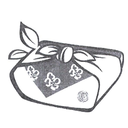

101009021
其他(雨傘.扇子.鑰匙.油漆刷子.鎖.哨子.拐杖.金箍棒) ; 其他紡織品(桌巾.窗簾)


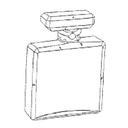

102045992
理容/化妝用品(口紅.香水.刮鬍刀.牙刷.鏡子) ; 器物


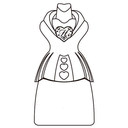

102061972
上身衣物 ; 下身衣物 ; 全身衣物 ; 特定形狀圖形


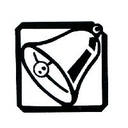

102880145
敲鐘/鈴鐺(不含時鐘)


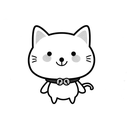

103001663
走獸 ; 敲鐘/鈴鐺(不含時鐘)


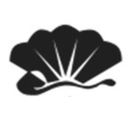

103023931
吸煙用品(煙斗.香煙.煙灰缸.打火機) ; 其他(雨傘.扇子.鑰匙.油漆刷子.鎖.哨子.拐杖.金箍棒) ; 不同幾何形狀組合/重疊或其他不規則圖形(不包含線條)


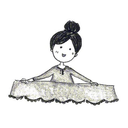

103032960
女人 ; 其他紡織品(桌巾.窗簾) ; 裝飾圖案/緞帶


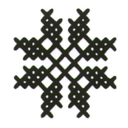

103058537
其他紡織品(桌巾.窗簾) ; 裝飾圖案/緞帶 ; 五角形以上外觀


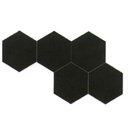

103059050
五角形以上外觀 ; 抽象幾何圖形


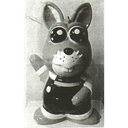

103064570
擬人化 ; 走獸 ; 動物


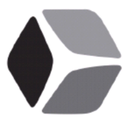

103066785
不同幾何形狀組合/重疊或其他不規則圖形(不包含線條) ; 抽象幾何圖形


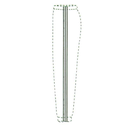

103928299
下身衣物 ; 線條/曲折區塊或其與幾何圖形之組合/重疊(對稱係指整體構圖而言)


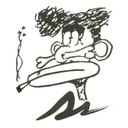

104000285
男人 ; 吸煙用品(煙斗.香煙.煙灰缸.打火機)


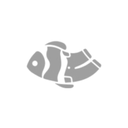

104026917
水族 ; 下身衣物


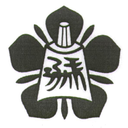

104036915
花/葉/草 ; 敲鐘/鈴鐺(不含時鐘) ; 圖形化中文


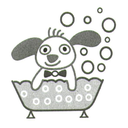

104042018
擬人化 ; 走獸 ; 衛浴設備(馬桶.浴缸.洗臉檯.水龍頭)


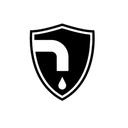

104042892
衛浴設備(馬桶.浴缸.洗臉檯.水龍頭) ; 盾牌 ; 特定形狀圖形


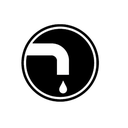

104042893
衛浴設備(馬桶.浴缸.洗臉檯.水龍頭) ; 圓形外觀 ; 特定形狀圖形


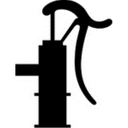

104057826
消防設備(滅火器.消防栓.雲梯) ; 其他(雨傘.扇子.鑰匙.油漆刷子.鎖.哨子.拐杖.金箍棒)


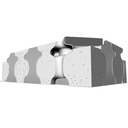

104062242
其他屋狀建築 ; 建築物


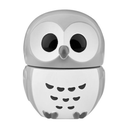

104069388
飛禽/蝙蝠 ; 動物


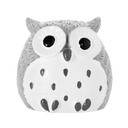

104069389
飛禽/蝙蝠 ; 動物


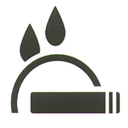

104074094
吸煙用品(煙斗.香煙.煙灰缸.打火機) ; 圓形外觀 ; 特定形狀圖形


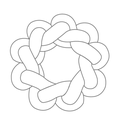

104077592
其他紡織品(桌巾.窗簾) ; 不同幾何形狀組合/重疊或其他不規則圖形(不包含線條)


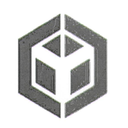

105038440
箭號或三角形外觀 ; 四角形外觀 ; 線條/曲折區塊或其與幾何圖形之組合/重疊(對稱係指整體構圖而言) ; 抽象幾何圖形


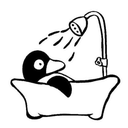

105052046
飛禽/蝙蝠 ; 衛浴設備(馬桶.浴缸.洗臉檯.水龍頭)


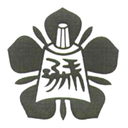

105055911
花/葉/草 ; 敲鐘/鈴鐺(不含時鐘) ; 圖形化中文


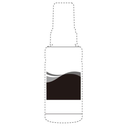

105057942
廚房設備/器皿(叉.盆.碗.壺.瓶.汽水瓶.鼎.尊.花瓶.杯子.杵臼) ; 線條/曲折區塊或其與幾何圖形之組合/重疊(對稱係指整體構圖而言) ; 器物


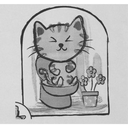

106008038
擬人化 ; 走獸 ; 花/葉/草 ; 衛浴設備(馬桶.浴缸.洗臉檯.水龍頭)


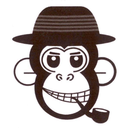

106025085
擬人化 ; 走獸 ; 吸煙用品(煙斗.香煙.煙灰缸.打火機) ; 帽子


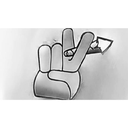

106025419
人體部位 ; 吸煙用品(煙斗.香煙.煙灰缸.打火機) ; 文具事務用品(筆.紙.刀片.印章.書.圓規.圖畫.掛畫)


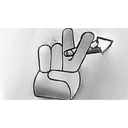

106025420
人體部位 ; 吸煙用品(煙斗.香煙.煙灰缸.打火機) ; 文具事務用品(筆.紙.刀片.印章.書.圓規.圖畫.掛畫)


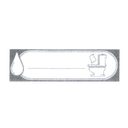

106048710
衛浴設備(馬桶.浴缸.洗臉檯.水龍頭) ; 特定形狀圖形


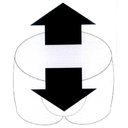

107052323
下身衣物 ; 箭號或三角形外觀


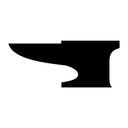

107056739
衛浴設備(馬桶.浴缸.洗臉檯.水龍頭) ; 不同幾何形狀組合/重疊或其他不規則圖形(不包含線條)


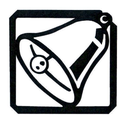

107058521
敲鐘/鈴鐺(不含時鐘)


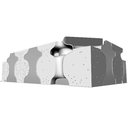

107069624
其他屋狀建築 ; 建築物


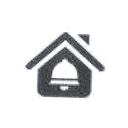

108007873
住屋 ; 敲鐘/鈴鐺(不含時鐘)


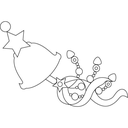

108013205
敲鐘/鈴鐺(不含時鐘)


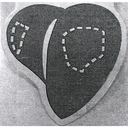

108040620
下身衣物 ; 特定形狀圖形


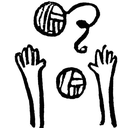

109022739
人體部位 ; 其他紡織品(桌巾.窗簾)


In [24]:
least_10_class_img = df_labels[(df_labels[x[-10:]].sum(axis=1) > 0)]
for i in least_10_class_img.index:
    labels = []
    for j in df_labels.columns:
        if df_labels.loc[i][j] > 0:
            labels.append(j)
    a = [labels_dict[i] for i in labels]
    img = Image.open(df_merge.loc[i].path)
    img = img.resize((128,128),Image.ANTIALIAS)
    display(img)
    print(i)
    print(f"{' ; '.join(a)}")

In [347]:
#印出各種圖片
def show_img_design(design, num=4):
    imgs = []
    a = list(data[data.design==design]['path'])
    if len(a) <= num:
        for i in a:
            img = Image.open( i )
            img = img.resize((128, 128), Image.ANTIALIAS)
            imgs.append(img)
    else:
        for i in range(num):
            img = Image.open( random.choice(a) )
            img = img.resize((128, 128), Image.ANTIALIAS)
            imgs.append(img)
    ipyplot.plot_images(imgs, max_images=num)
#     display(imgs)

In [ ]:
imgs = []
miss_imgs = []
for i in  df_path.path:
    try:
        img = Image.open(i)
        img = img.resize((128, 128), Image.ANTIALIAS)
        imgs.append(img)
    except:
        miss_imgs.append(i)
print(miss_imgs) 
# with open('miss_imgs', 'w') as f:
#     for line in miss_imgs:
#         f.write(line)
#         f.write('\n')

ipyplot.plot_images(imgs, max_images=1000)


In [19]:
# df_labels.to_csv('labels.csv', index=True)
# df_path.to_csv('path.csv', index=True)

In [20]:
df_labels = pd.read_csv('labels.csv',index_col='caseno')
df_path = pd.read_csv('path.csv',index_col='caseno')
# df_path

In [346]:
for i in df_labels.sample(10).index:
    labels = []
    for j in df_labels.columns:
        if df_labels.loc[i][j] > 0:
            labels.append(j)
    a = [labels_dict[i] for i in labels]
    img = Image.open(df_merge.loc[i].path)
    img = img.resize((128,128),Image.ANTIALIAS)
    display(img)
    print(i)
    print(f"{' ; '.join(a)}")

NameError: name 'df_merge' is not defined

# Load image

In [2]:
df_labels = pd.read_csv('labels.csv',index_col='caseno')
df_path = pd.read_csv('path.csv',index_col='caseno')
# df_merge = pd.concat([df_path, df_labels], axis=1)
# df_merge

In [3]:
miss_imgs = []
with open('miss_imgs', 'r') as f:
        miss_imgs = f.readlines()
        miss_imgs = [i.strip() for i in miss_imgs]
print(miss_imgs)

['/service/trademark/raw_register_data/TrademarkRegXMLB_040011/imagesdata/egimg_101056946_1_040011.jpg']


In [4]:
# df_merge = df_merge[~df_merge.path.isin(miss_imgs)]

In [5]:
miss = df_path.path.isin(miss_imgs)
df_labels = df_labels[~miss]
df_path = df_path[~miss]


<ipython-input-5-02a4fc6e69d1>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_labels = df_labels[~miss]


In [6]:
class train_set(Dataset):
    def __init__(self, df_labels, df_path, transform):
        self.df_merge = pd.concat([df_path, df_labels], axis=1)
        self.df_merge = self.df_merge[:int(self.df_merge.shape[0]*0.8)]
        self.transform = transform
        self.labels = self.df_merge.drop(columns=['filename', 'path']).values
        self.labels = self.labels.astype('float32')
        self.path = self.df_merge[['path']].values
    
    def __len__(self):
        return self.labels.shape[0]
    
    def __getitem__(self, idx):
        image = Image.open(self.path[idx][0]).convert('RGB')
        label = self.labels[idx]
        image = self.transform(image)
        return image, label

class test_set(Dataset):
    def __init__(self, df_labels, df_path, transform):
        self.df_merge = pd.concat([df_path, df_labels], axis=1)
        self.df_merge = self.df_merge[int(self.df_merge.shape[0]*0.8):]
        self.transform = transform
        self.labels = self.df_merge.drop(columns=['filename', 'path']).values
        self.labels = self.labels.astype('float32')
        self.path = self.df_merge[['path']].values
        self.label_code = self.df_merge.drop(columns=['filename', 'path']).columns
    
    def __len__(self):
        return self.labels.shape[0]
    
    def __getitem__(self, idx):
        image = Image.open(self.path[idx][0]).convert('RGB')
        label = self.labels[idx]
        image = self.transform(image)
        
        return image, label
    


In [7]:
np.random.seed(0)
permutation = list(df_labels.index)
np.random.shuffle(permutation)
# print(permutation)
df_path = df_path.loc[permutation]
df_labels = df_labels.loc[permutation]

In [8]:
train_data = train_set(df_labels, df_path, transform=transforms.Compose([
#     transforms.Grayscale(num_output_channels=1),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    
    ###### data augmentation
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=(0, 5), contrast=(0, 5), saturation=(0, 5), hue=(-0.1, 0.1)),
    ######
    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]))

test_data = test_set(df_labels, df_path, transform=transforms.Compose([
#     transforms.Grayscale(num_output_channels=1),
    transforms.Resize(256), 
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]))

In [9]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16,shuffle=True,num_workers=6,pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1,shuffle=False)
print(len(train_loader))
print(len(test_loader))

1604
6414


In [10]:
df_labels.values.dtype

dtype('float64')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([16, 3, 224, 224])
Labels batch shape: torch.Size([16, 94])


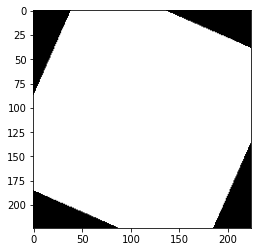

Label: 線條/曲折區塊或其與幾何圖形之組合/重疊(對稱係指整體構圖而言) ; 不同幾何形狀組合/重疊或其他不規則圖形(不包含線條)


In [11]:
# Display image and label.
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze().numpy()
img = np.transpose(img, (1, 2, 0))
labels = []
for i, j in enumerate(train_labels[0]):
    if j > 0:
        labels.append(df_labels.columns[i])
label = [labels_dict[i] for i in labels]
plt.imshow(img)
plt.show()
print(f"Label: {' ; '.join(label)}")

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def resnet(model,  requires_grad=True):
    if requires_grad == False:
        for param in model.parameters():
            param.requires_grad = False
    num_ftrs = model.fc.in_features 
    model.fc = torch.nn.Linear(num_ftrs, len(df_labels.columns))
    return model

def densenet(model,  requires_grad=True):
    if requires_grad == False:
        for param in model.parameters():
            param.requires_grad = False
    num_ftrs = model.classifier.in_features 
    model.classifier = torch.nn.Linear(num_ftrs, len(df_labels.columns))
    return model

In [13]:

model = resnet(models.resnet152(pretrained=True), requires_grad=True)
# model = densenet(models.densenet201(pretrained=True), requires_grad=True)
model = model.to(device)


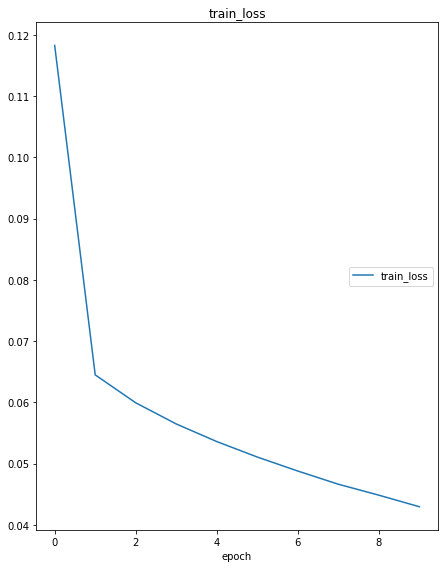

train_loss
	train_loss       	 (min:    0.043, max:    0.118, cur:    0.043)
Finished Training
CPU times: user 1h 1min 29s, sys: 9min 45s, total: 1h 11min 14s
Wall time: 1h 10min 17s


In [14]:
%%time
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

num_epochs = 10
liveloss = PlotLosses()

# Train
for epoch in range(num_epochs):
    print("epoch :", epoch)
    logs = {}
    running_loss = 0.0
#     train_accs = []
#     test_accs = []
    test_loss = []
    model.train()
    for times, data in enumerate(tqdm(train_loader)):
        model.train()
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(inputs)
        outputs = torch.sigmoid(outputs)
#         acc = (outputs.argmax(dim=-1) == labels.to(device)).float().mean()
#         train_accs.append(acc)
        loss = criterion(outputs, labels)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
        

    logs['train_loss'] = running_loss/times
    
#     with torch.no_grad():
#         for data in tqdm(test_loader):
#             model.eval()
#             inputs, labels = data
#             inputs, labels = inputs.to(device), labels.to(device)
#             outputs = model(inputs)
#             outputs = torch.sigmoid(outputs)
#             loss = criterion(outputs, labels)
            
#             test_loss.append(loss.detach().item())
# #             acc = (outputs.argmax(dim=-1) == labels.to(device)).float().mean()
# #             test_accs.append(acc)

#     logs['test_loss'] = sum(test_loss) / len(test_loss)
    
    
    liveloss.update(logs)
    liveloss.send()
print('Finished Training')

In [32]:
PATH = "model.pt"
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, PATH)

In [14]:
PATH = "model.pt"
checkpoint = torch.load(PATH)
model = resnet(models.resnet152(pretrained=True), requires_grad=True)
num_ftrs = model.fc.in_features 
model.fc = torch.nn.Linear(num_ftrs, len(df_labels.columns))
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)

In [ ]:
threshold = 0.5
title = []
imgs = []
with torch.no_grad():
    for i, data in enumerate(tqdm(test_loader)):
        model.eval()
        if i % 40 == 1:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            outputs = torch.sigmoid(outputs).cpu()
            outputs = outputs.numpy()
            pred = test_loader.dataset.label_code[(outputs[0])>threshold].tolist()
            if len(pred) == 0:
                pred = [ test_loader.dataset.label_code[np.argmax(outputs[0])]]
            img = Image.open(test_loader.dataset.path[i][0])
            caseno = test_loader.dataset.df_merge.index[i]
            img = img.resize((128,128),Image.ANTIALIAS)
    #             display(img)
            label = [labels_dict[i] for i in pred]
    #             img = inputs.cpu().squeeze().numpy()
    #             img = np.transpose(img, (1, 2, 0))
    #             plt.imshow((img))
    #             plt.show()

    #             print(f"pred labels : {' ; '.join(label)}")
            gd = test_loader.dataset.label_code[test_loader.dataset.labels[i]>0]
    #             print(f"ground truth: {' ; '.join([labels_dict[i] for i in gd])}")

            title.append("caseno: {}\nPred Labels : {}\nGround Truth: {}".format(caseno, ' ; '.join(label), ' ; '.join([labels_dict[i] for i in gd])))
            imgs.append(img)
ipyplot.plot_class_representations(imgs, title, img_width=200)

In [21]:
threshold = 0.5
y_pred = []
y_true = []
top1_y_acc = []
top3_y_acc = []
top5_y_acc = []
with torch.no_grad():
    for i, data in enumerate(tqdm(test_loader)):
        model.eval()
        if True:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)[0]
            
            outputs = torch.sigmoid(outputs).cpu()
            outputs = outputs.numpy()
            
            # binary
            binary_output = (outputs > threshold).astype(int)
            if 1 not in binary_output:
                binary_output[np.argmax(outputs)] = 1
            y_pred.append(binary_output)
            
            #top 1
            top1_index = np.argsort(outputs)[-1:][::-1]
            hit = False
            for index in top1_index:
                if (test_loader.dataset.labels[i]>0).astype(int)[index] > 0:
                    hit = True
            if hit is True:
                top1_y_acc.append(1)
            else:
                top1_y_acc.append(0)
                
            # top 3
            top3_index = np.argsort(outputs)[-3:][::-1]
            hit = False
            for index in top3_index:
                if (test_loader.dataset.labels[i]>0).astype(int)[index] > 0:
                    hit = True
            if hit is True:
                top3_y_acc.append(1)
            else:
                top3_y_acc.append(0)
#             print(outputs)
#             print(np.argsort(outputs)[-3:][::-1])
#             print(max(outputs))
#             print(np.argmax(outputs))
    
            # top 5
            top5_index = np.argsort(outputs)[-5:][::-1]
            hit = False
            for index in top5_index:
                if (test_loader.dataset.labels[i]>0).astype(int)[index] > 0:
                    hit = True
            if hit is True:
                top5_y_acc.append(1)
            else:
                top5_y_acc.append(0)
    
            y_true.append((test_loader.dataset.labels[i]>0).astype(int))

y_pred = np.stack(y_pred, axis=0)
y_true = np.stack(y_true, axis=0)


100%|██████████| 6414/6414 [01:48<00:00, 58.87it/s]


In [22]:
# def Hamming_Loss(y_true, y_pred):
#     temp=0
#     for i in range(y_true.shape[0]):
#         temp += np.size(y_true[i] == y_pred[i]) - np.count_nonzero(y_true[i] == y_pred[i])
#     return temp/(y_true.shape[0] * y_true.shape[1])
# def Accuracy(y_true, y_pred):
#     temp = 0
#     for i in range(y_true.shape[0]):
#         temp += sum(np.logical_and(y_true[i], y_pred[i])) / sum(np.logical_or(y_true[i], y_pred[i]))
#     return temp / y_true.shape[0]
# def Precision(y_true, y_pred):
#     temp = 0
#     for i in range(y_true.shape[0]):
#         if sum(y_true[i]) == 0:
#             continue
#         temp += sum(np.logical_and(y_true[i], y_pred[i]))/ sum(y_true[i])
#     return temp/ y_true.shape[0]
# def Recall(y_true, y_pred):
#     temp = 0
#     for i in range(y_true.shape[0]):
#         if sum(y_pred[i]) == 0:
#             continue
#         temp += sum(np.logical_and(y_true[i], y_pred[i]))/ sum(y_pred[i])
#     return temp/ y_true.shape[0]

# def F1Measure(y_true, y_pred):
#     temp = 0
#     for i in range(y_true.shape[0]):
#         if (sum(y_true[i]) == 0) and (sum(y_pred[i]) == 0):
#             continue
#         temp+= (2*sum(np.logical_and(y_true[i], y_pred[i])))/ (sum(y_true[i])+sum(y_pred[i]))
#     return temp/ y_true.shape[0]

# def evaluation(y_true, y_pred):
#     print(f"Hamming loss :{Hamming_Loss(y_true, y_pred)}")
#     print(f"Accuracy     :{Accuracy(y_true, y_pred)}")
#     print(f"Precision    :{Precision(y_true, y_pred)}")
#     print(f"Recall       :{Recall(y_true, y_pred)}")
#     print(f"F1Measure    :{F1Measure(y_true, y_pred)}")
    
# evaluation(y_true, y_pred)

圖片平均label數  
去掉較少的label & 合併class  

macro & micro average

定義答對: e.g. 兩個label猜到一個
precision & recall 有問題

top 3 : 前三個有碰到正確label就好

每一個 class 都算一個 threshold  maximize f1

試試看新增17大類的label

accuracy 計算有問題 應該會比較大

### TOP-N Accuracy
前 N 個機率最大的output 中包含到任意一個 ground truth 即視為預測正確

In [23]:
def topN():
    print("top 1: {:.3f}".format(sum(top1_y_acc)/len(top1_y_acc)))
    print("top 3: {:.3f}".format(sum(top3_y_acc)/len(top3_y_acc)))
    print("top 5: {:.3f}".format(sum(top5_y_acc)/len(top5_y_acc)))
topN()

top 1: 0.741
top 3: 0.896
top 5: 0.942


## Confusion Matrix

threshold 為 0.5

tp: 預測positive結果正確  
fp: 預測positive結果錯誤  
tn: 預測negative結果正確   
fn: 預測negative結果錯誤  

tp+fp = 預測為positive的數量  
tn+fn = 預測為negative的數量  

tp+tn = 預測正確的數量  
fp+fn = 預測錯誤的數量  

In [24]:
tp = []
tn = []
fp = []
fn = []
for i in range(y_pred.shape[1]):
    pred = y_pred[:,i]
    true = y_true[:,i]

    tp.append(np.logical_and(pred, true).sum())
    
    fp.append(pred.sum()-np.logical_and(pred, true).sum())

    tn.append((pred==true).sum()-np.logical_and(pred, true).sum())


    cnt = 0
    for m, n in zip(y_pred[:,i], y_true[:,i]):
        if m==0 and n==1:
            cnt += 1
    fn.append(cnt)
tp = np.array(tp)
fp = np.array(fp)
tn = np.array(tn)
fn = np.array(fn)

## Macro-average
所有類別先各自計算 recall & precision 再取算術平均
Use macro-averaging score when all classes need to be treated equally to evaluate the overall performance of the classifier with regard to the most frequent class labels.  

In [25]:
def macro():
    accuracy = ((tp+tn)/(tp+fp+tn+fn))
    print("Accuracy : {:.3f}".format(   accuracy.mean()))
    recall = tp/(tp+fn)
    print("Recall   : {:.3f}".format(   recall[~np.isnan(recall)].mean()    ))
    precision = tp/(tp+fp)
    print("Precision: {:.3f}".format(   precision[~np.isnan(precision)].mean()    ))

macro()

Accuracy : 0.987
Recall   : 0.226
Precision: 0.719


<ipython-input-25-22db24a57a9b>:4: RuntimeWarning: invalid value encountered in true_divide
  recall = tp/(tp+fn)
<ipython-input-25-22db24a57a9b>:6: RuntimeWarning: invalid value encountered in true_divide
  precision = tp/(tp+fp)


## Micro-average
Micro-averaging recall scores is sum of true positive for individual classes divided by sum of actual positives for all classes.   
Micro-averaging precision scores is sum of true positive for individual classes divided by sum of predicted positives for all classes  
Use micro-averaging score when there is a need to weight each instance or prediction equally.

In [26]:
def micro():
    print("Recall   : {:.3f}".format(   tp.sum()/(tp.sum() + fn.sum())  ))
    print("Precision: {:.3f}".format(   tp.sum()/(tp.sum() + fp.sum())  ))
micro()

Recall   : 0.528
Precision: 0.726


## Weighted-average
根據各個 class 數量的比例去加權  (比如人類這個類別有 100筆， 非人類的類別有 900筆， 人類的權重為 100/1000 = 0.1)

In [27]:
def weighted():
    weights = y_true.sum(axis=0)/y_true.sum()
    accuracy = ((tp+tn)/(tp+fp+tn+fn))
    print("Accuracy : {:.3f}".format(  np.dot(accuracy, weights)))
    recall = tp/(tp+fn)
    print("Recall : {:.3f}".format(  np.dot(recall[~np.isnan(recall)], weights[~np.isnan(recall)])   ))
    
    precision = tp/(tp+fp)
    print("Precision : {:.3f}".format(  np.dot(precision[~np.isnan(precision)], weights[~np.isnan(precision)])   ))
weighted()

Accuracy : 0.951
Recall : 0.528
Precision : 0.683


<ipython-input-27-92ac9893388d>:5: RuntimeWarning: invalid value encountered in true_divide
  recall = tp/(tp+fn)
<ipython-input-27-92ac9893388d>:8: RuntimeWarning: invalid value encountered in true_divide
  precision = tp/(tp+fp)


## Summary

In [28]:
def summary():
    print("-----top N------")
    topN()
    print("-----Macro-----")
    macro()
    print("-----Micro-----")
    micro()
    print("-----Weighted-----")
    weighted()
summary()

-----top N------
top 1: 0.741
top 3: 0.896
top 5: 0.942
-----Macro-----
Accuracy : 0.987
Recall   : 0.226
Precision: 0.719
-----Micro-----
Recall   : 0.528
Precision: 0.726
-----Weighted-----
Accuracy : 0.951
Recall : 0.528
Precision : 0.683


<ipython-input-25-22db24a57a9b>:4: RuntimeWarning: invalid value encountered in true_divide
  recall = tp/(tp+fn)
<ipython-input-25-22db24a57a9b>:6: RuntimeWarning: invalid value encountered in true_divide
  precision = tp/(tp+fp)
<ipython-input-27-92ac9893388d>:5: RuntimeWarning: invalid value encountered in true_divide
  recall = tp/(tp+fn)
<ipython-input-27-92ac9893388d>:8: RuntimeWarning: invalid value encountered in true_divide
  precision = tp/(tp+fp)


## 問題
* 目前的資料過濾掉圖中有文字的彩色平面部分
* 重複的圖片要怎麼辦

計算column wise 的 presion & recall 

NDCG

篩掉重複圖片:  
pretrain model 倒數第二層  
cosine similarity (L2) 設threshold 去篩

## Get laten vector

### trainloader 記得不要 shuffle

In [74]:
model_no_fc = torch.nn.Sequential(*(list(model.children())[:-1]))
model_no_fc.eval()
model_no_fc.training

False

In [79]:
train_data = train_set(df_labels, df_path, transform=transforms.Compose([
#     transforms.Grayscale(num_output_channels=1),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]))
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16,shuffle=False,num_workers=6,pin_memory=True)

laten_vec_train = []
with torch.no_grad():
    for i, (x, y) in enumerate(tqdm(train_loader)):
        x = x.to(device)
        out = model_no_fc(x).cpu()
        out = torch.squeeze(out)
        out = out.numpy()
        
#         y = y.numpy().reshape(-1,1)+1
        
#         print(np.concatenate((out, y), axis=1))
#         print(out.shape)
#         break
#         img_vectors.append(np.concatenate((out, y), axis=1))
        laten_vec_train.append(out)


laten_vec_train = np.vstack(laten_vec_train)

100%|██████████| 1604/1604 [01:58<00:00, 13.55it/s]


In [76]:
imgs = []
laten_vec_test = []
with torch.no_grad():
    for i, data in enumerate(tqdm(test_loader)):
        model.eval()
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        ##laten vector
        out = model_no_fc(inputs).cpu()
        out = torch.squeeze(out)
        out = out.numpy()
        laten_vec_test.append(out)

        img = Image.open(test_loader.dataset.path[i][0])
        img = img.resize((128,128),Image.ANTIALIAS)

        imgs.append(img)
laten_vec_test = np.stack(laten_vec_test)


100%|██████████| 6414/6414 [02:22<00:00, 44.91it/s]


In [80]:
print(laten_vec_train.shape)
print(laten_vec_test.shape)

(25652, 2048)
(6414, 2048)


## k-means

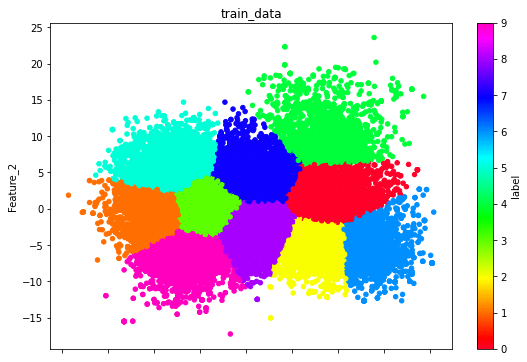

In [90]:
tmp = PCA(2, random_state=4096).fit_transform(laten_vec_train) 
kmeans = KMeans(n_clusters=10, random_state=0).fit(tmp)
df = pd.DataFrame(dict(Feature_1=tmp[:,0], Feature_2=tmp[:,1], label=kmeans.labels_))
df.plot(x="Feature_1", y="Feature_2", kind='scatter', c='label', colormap='gist_rainbow', figsize=(9,6), title='train_data')
# df.plot(x="Feature_1", y="Feature_2", kind='scatter', c='label', colormap='gist_rainbow', figsize=(36,24))
plt.show()

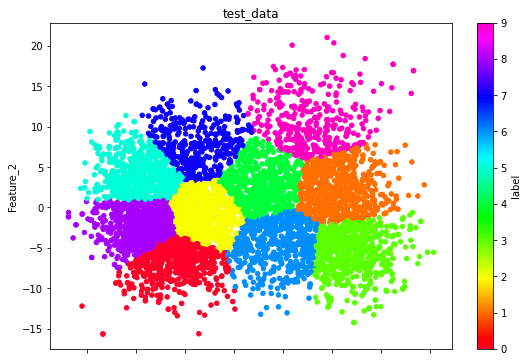

In [91]:
tmp = PCA(2, random_state=4096).fit_transform(laten_vec_test) 
kmeans = KMeans(n_clusters=10, random_state=0).fit(tmp)
df = pd.DataFrame(dict(Feature_1=tmp[:,0], Feature_2=tmp[:,1], label=kmeans.labels_))
df.plot(x="Feature_1", y="Feature_2", kind='scatter', c='label', colormap='gist_rainbow', figsize=(9,6), title='test_data')
# df.plot(x="Feature_1", y="Feature_2", kind='scatter', c='label', colormap='gist_rainbow', figsize=(36,24))
plt.show()

## Retrieval (Cosine similarity)

In [92]:
laten_vec_train.shape

(25652, 2048)

In [93]:
laten_vec_test.shape

(6414, 2048)

In [94]:
def cosine_similarity(x, y):
    a = np.dot(x, y)
    b = np.linalg.norm(x) * np.linalg.norm(y)
    return a/b

### 用一個 test_data laten vector 去檢索( cosine similarity )其他 test data

0 擬人化


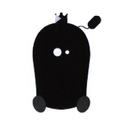


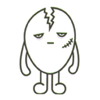
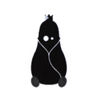
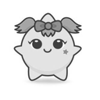
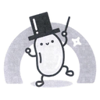
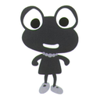
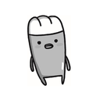
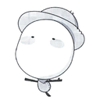
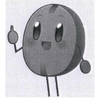
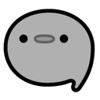
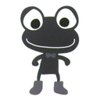
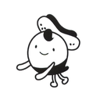
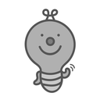
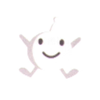
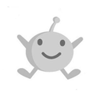
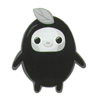
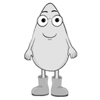
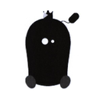
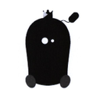


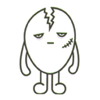
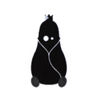
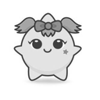
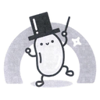
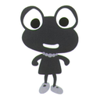
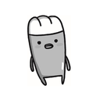
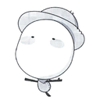
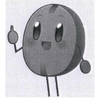
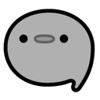
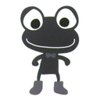
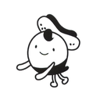
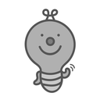
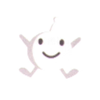
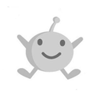
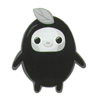
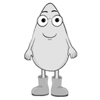
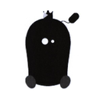
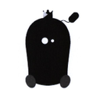



1 圓形外觀


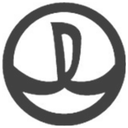


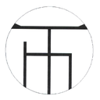
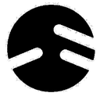
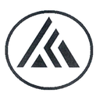
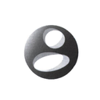
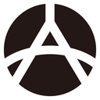
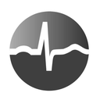
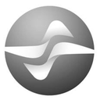
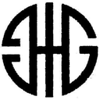
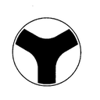
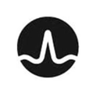
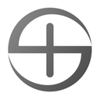
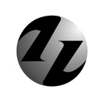
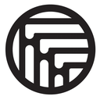
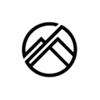
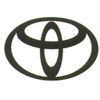
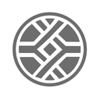
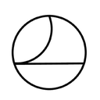
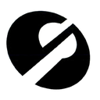
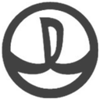


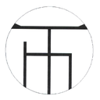
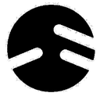
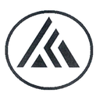
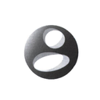
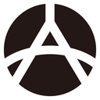
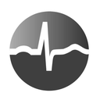
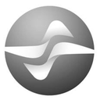
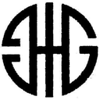
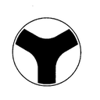
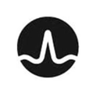
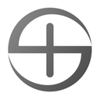
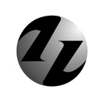
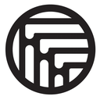
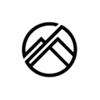
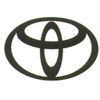
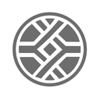
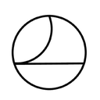
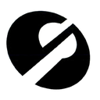
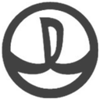



2 小孩/嬰兒


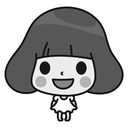


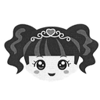
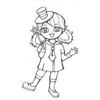
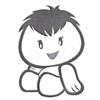
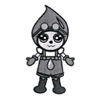
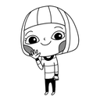
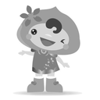
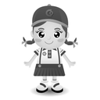
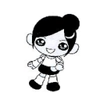
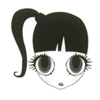
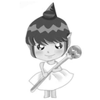
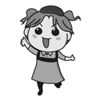
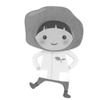
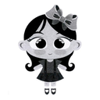
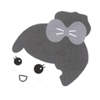
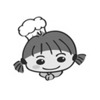
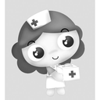
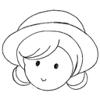
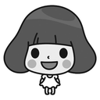


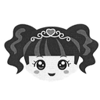
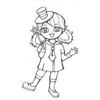
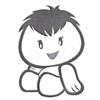
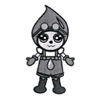
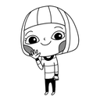
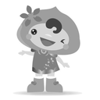
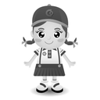
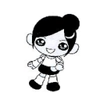
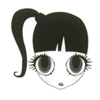
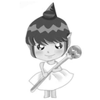
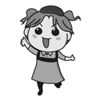
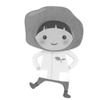
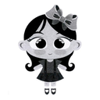
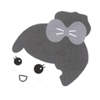
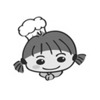
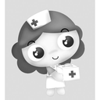
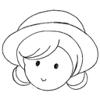
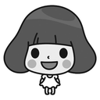



3 小孩/嬰兒


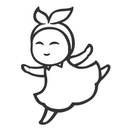


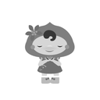
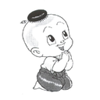
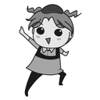
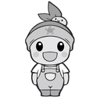
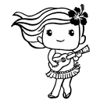
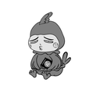
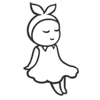
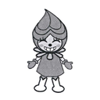
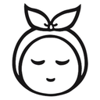
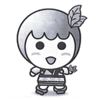
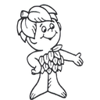
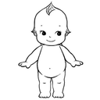
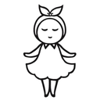
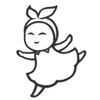


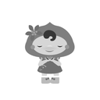
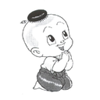
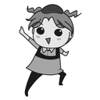
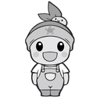
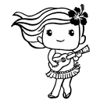
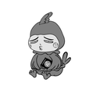
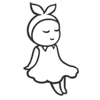
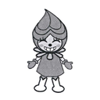
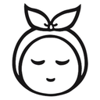
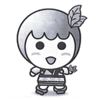
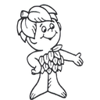
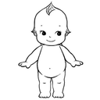
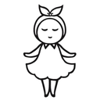
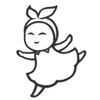



4 圓形外觀 ; 不同幾何形狀組合/重疊或其他不規則圖形(不包含線條)


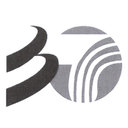


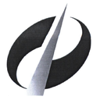
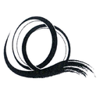
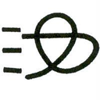
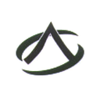
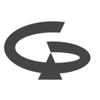
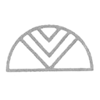
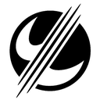
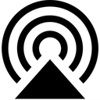
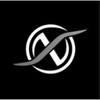
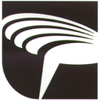
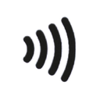
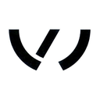
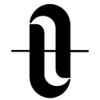
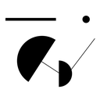
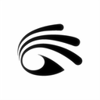
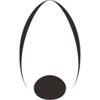
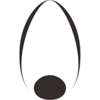
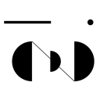
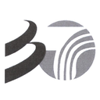


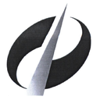
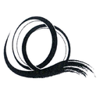
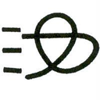
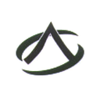
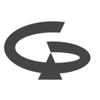
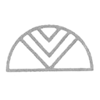
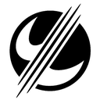
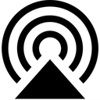
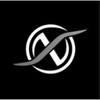
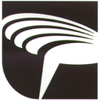
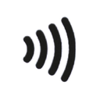
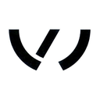
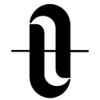
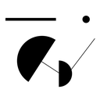
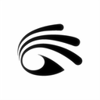
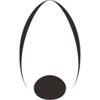
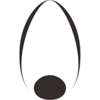
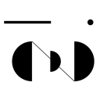
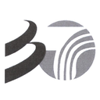



5 住屋 ; 不同幾何形狀組合/重疊或其他不規則圖形(不包含線條)


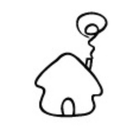


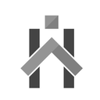
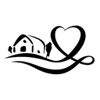
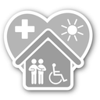
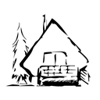
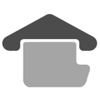
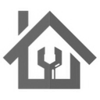
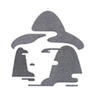
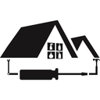
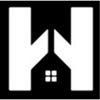
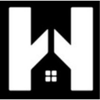
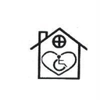
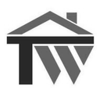
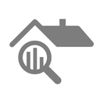
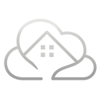
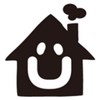
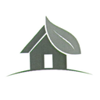
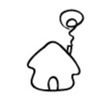


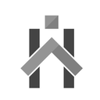
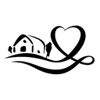
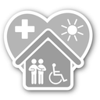
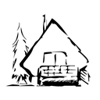
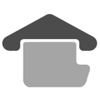
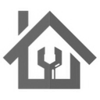
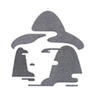
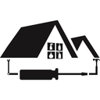
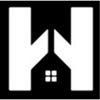
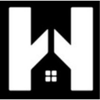
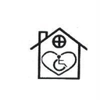
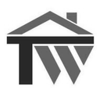
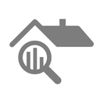
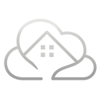
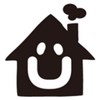
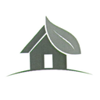
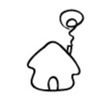



6 天體 ; 景觀


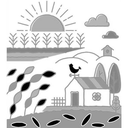


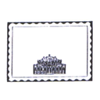
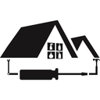
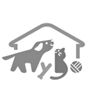
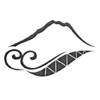
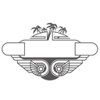
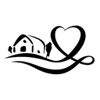
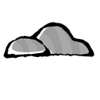
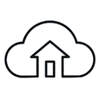
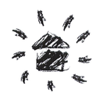
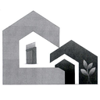
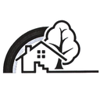
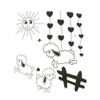
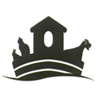
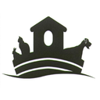
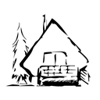
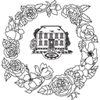
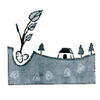
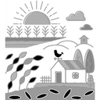


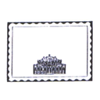
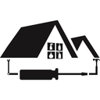
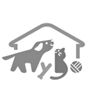
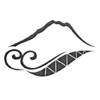
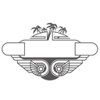
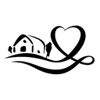
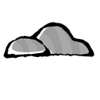
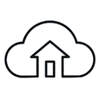
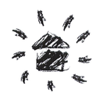
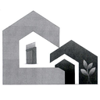
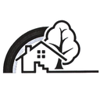
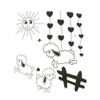
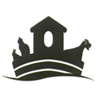
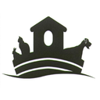
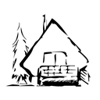
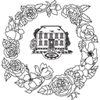
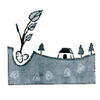
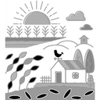



7 花/葉/草 ; 圓形外觀


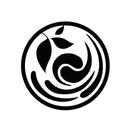


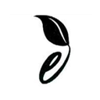
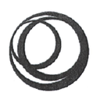
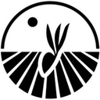
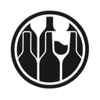
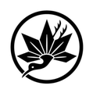
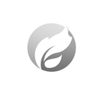
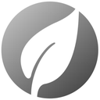
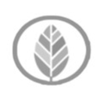
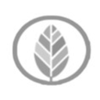
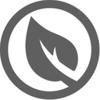
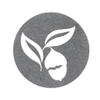
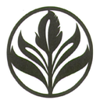
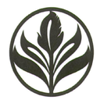
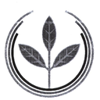
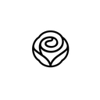
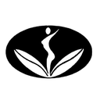
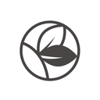
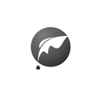
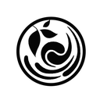


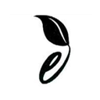
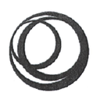
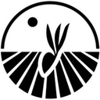
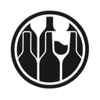
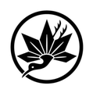
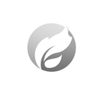
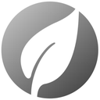
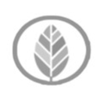
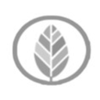
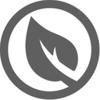
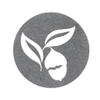
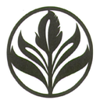
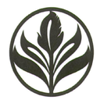
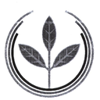
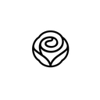
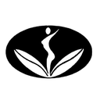
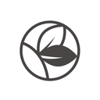
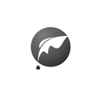
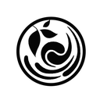



8 多種植物組合 ; 廚房設備/器皿(叉.盆.碗.壺.瓶.汽水瓶.鼎.尊.花瓶.杯子.杵臼)


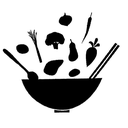


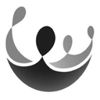
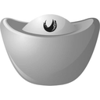
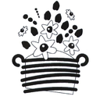
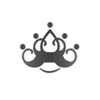
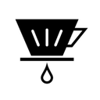
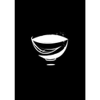
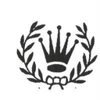
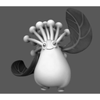
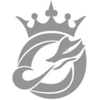
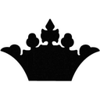
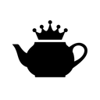
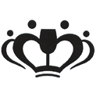
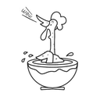
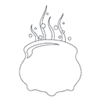
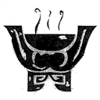
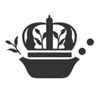
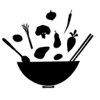


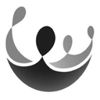
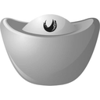
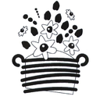
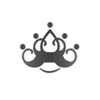
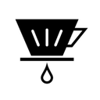
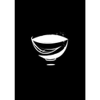
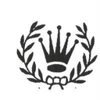
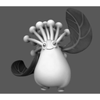
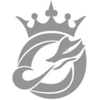
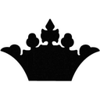
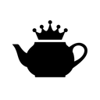
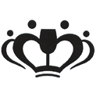
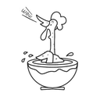
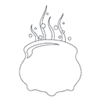
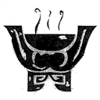
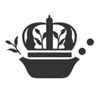
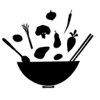



9 假想獸及古代動物


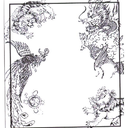


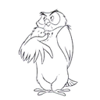
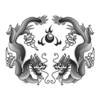
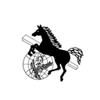
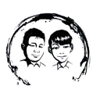
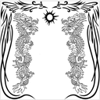
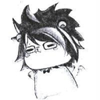
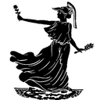
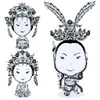
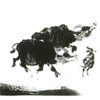
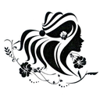
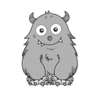
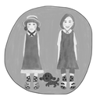
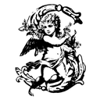
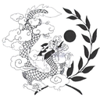
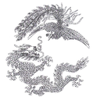
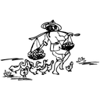
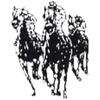
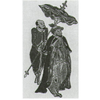
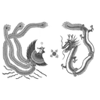
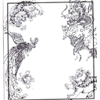


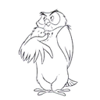
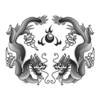
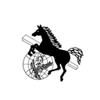
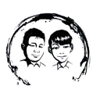
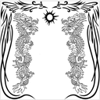
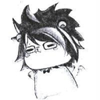
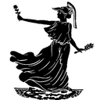
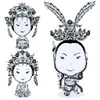
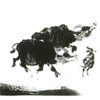
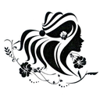
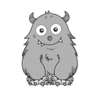
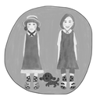
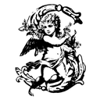
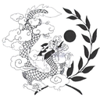
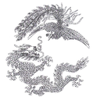
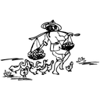
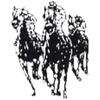
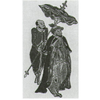
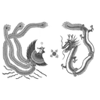
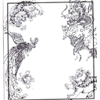

In [126]:
for num in range(10):
#     i = random.randint(0, len(laten_vec_test))
    i = num
    similarities = []
    for v in laten_vec_test:
        similarities.append(cosine_similarity(laten_vec_test[i], v))
    index = np.argsort(similarities)[-20:]  # Returns the indices that would sort an array. 取倒數20個也就是前20大的index
    
    
    gd = test_loader.dataset.label_code[test_loader.dataset.labels[i]>0]
    print(i, ' ; '.join([labels_dict[i] for i in gd]))
    display(imgs[i])
    temp = []
    for p in test_data.path[index]:
        img = Image.open(p[0])
        img = img.resize((128,128),Image.ANTIALIAS)
        temp.append(img)
        
    ipyplot.plot_class_representations(temp, np.array(similarities)[index], img_width=100)
    print("\n")


### 用一個 test_data laten vector 去檢索( cosine similarity ) train data

0 擬人化


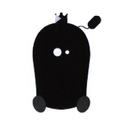


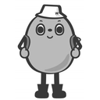
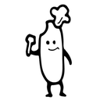
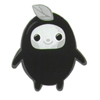
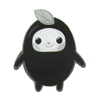
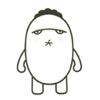
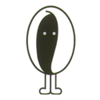
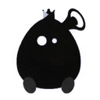
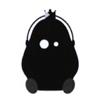
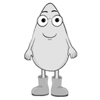
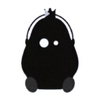


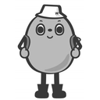
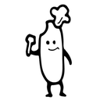
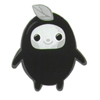
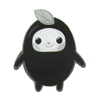
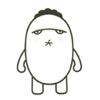
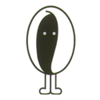
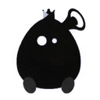
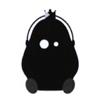
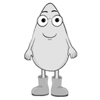
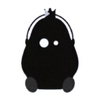



1 圓形外觀


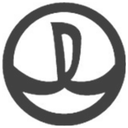


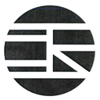
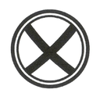
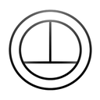
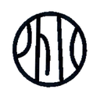
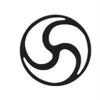
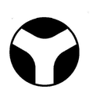
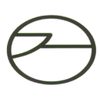
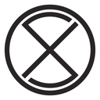
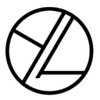
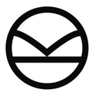


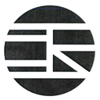
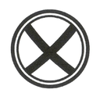
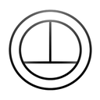
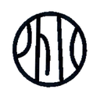
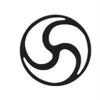
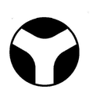
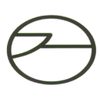
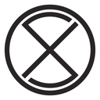
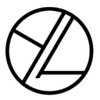
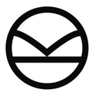



2 小孩/嬰兒


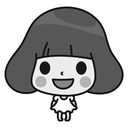


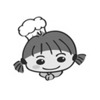
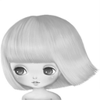
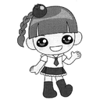
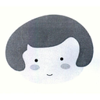
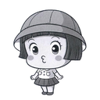
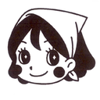
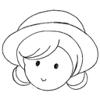
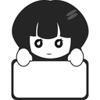


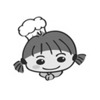
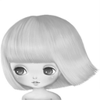
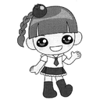
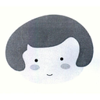
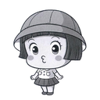
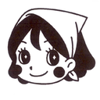
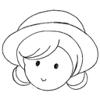
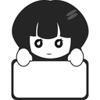



3 小孩/嬰兒


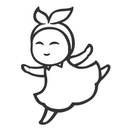


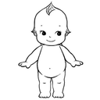
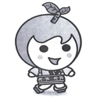
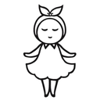
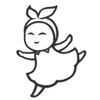


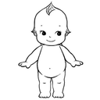
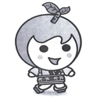
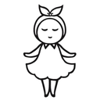
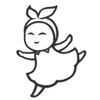



4 圓形外觀 ; 不同幾何形狀組合/重疊或其他不規則圖形(不包含線條)


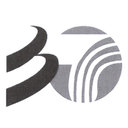


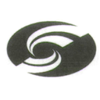
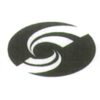
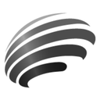
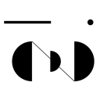
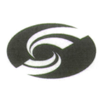
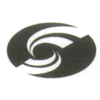
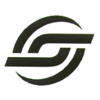
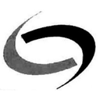


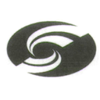
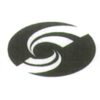
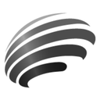
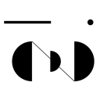
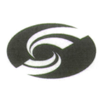
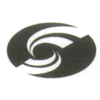
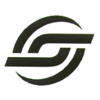
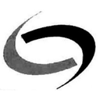



5 住屋 ; 不同幾何形狀組合/重疊或其他不規則圖形(不包含線條)


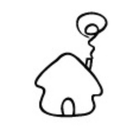


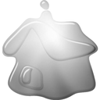
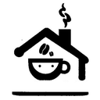
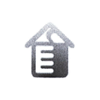
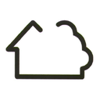
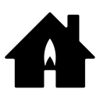
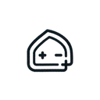
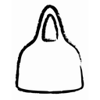
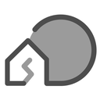
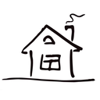
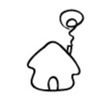


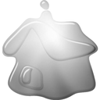
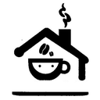
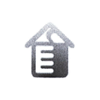
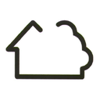
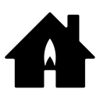
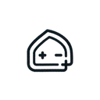
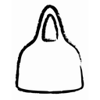
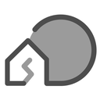
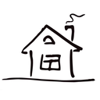
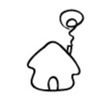



6 天體 ; 景觀


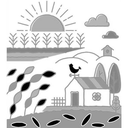


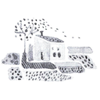
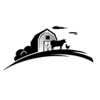
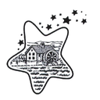
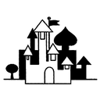
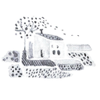
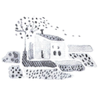
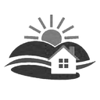
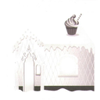
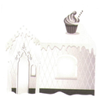


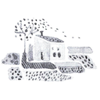
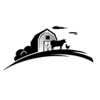
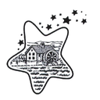
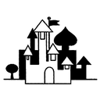
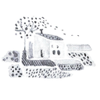
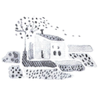
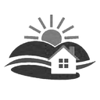
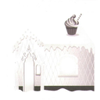
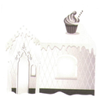



7 花/葉/草 ; 圓形外觀


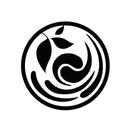


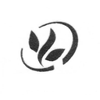
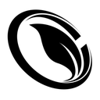
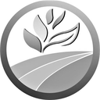
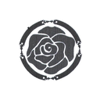
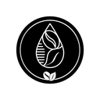
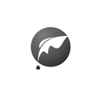
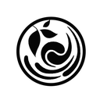


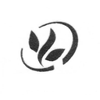
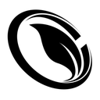
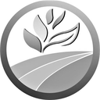
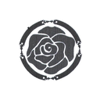
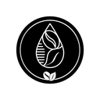
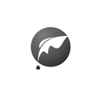
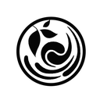



8 多種植物組合 ; 廚房設備/器皿(叉.盆.碗.壺.瓶.汽水瓶.鼎.尊.花瓶.杯子.杵臼)


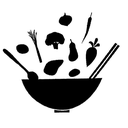


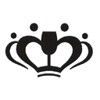
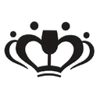
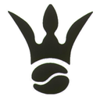
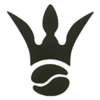
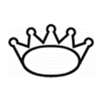
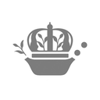
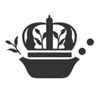
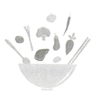
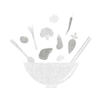
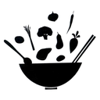


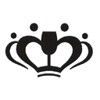
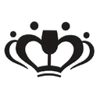
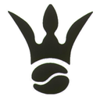
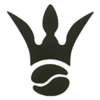
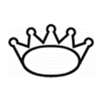
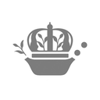
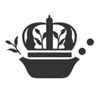
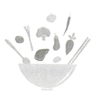
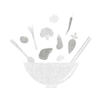
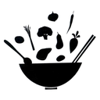



9 假想獸及古代動物


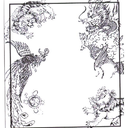


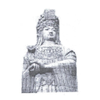
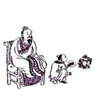
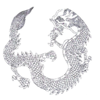
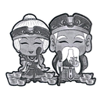
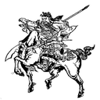
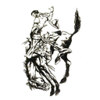
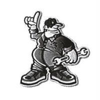
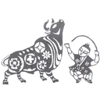
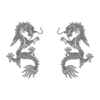


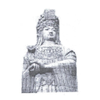
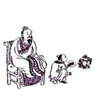
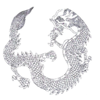
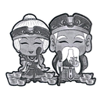
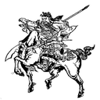
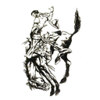
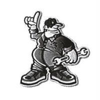
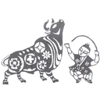
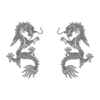

In [123]:
for num in range(10):
#     i = random.randint(0, len(laten_vec_train))
    i = num
    similarities = []
    for v in laten_vec_train:
        similarities.append(cosine_similarity(laten_vec_test[i], v))
    index = np.argsort(similarities)[-10:]  # Returns the indices that would sort an array. 取倒數20個也就是前20大的index
    
    
    gd = test_loader.dataset.label_code[test_loader.dataset.labels[i]>0]
    print(i, ' ; '.join([labels_dict[i] for i in gd]))
    display(imgs[i])
    temp = []
    titles = []
    for p in train_data.path[index]:
        img = Image.open(p[0])
        img = img.resize((128,128),Image.ANTIALIAS)
        temp.append(img)
#     temp.insert(0, imgs[i])
#     titles = list(np.array(similarities)[index])
#     titles.insert(0, str(i) +' ; '.join([labels_dict[i] for i in gd]))

    ipyplot.plot_class_representations(temp, np.array(similarities)[index], img_width=100)
    print("\n")
